### 06/25/23
### Joshua Edelstein
# Pneumonia Analysis
## Overview


## Business Understanding 

<div>
<img src="images/xray.jpg", width = 800, height = 400/>
</div>

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/x-ray?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Inspect and Prepare Data

### Loading the data
We'll begin our analysis by loading our data as a pandas dataframe. First we will import everything that we may need then we will move on to loading the data

In [1]:
import pandas as pd       

import numpy as np
from numpy.random import seed
seed(123)

import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

from sklearn.metrics import classification_report, confusion_matrix

import random
import os

random.seed(123)
os.environ['PYTHONHASHSEED'] = str(123)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(123)# Set the random seed for TensorFlow
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import callbacks
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import glob
import cv2

from tensorflow.random import set_seed
set_seed(123)

import warnings
warnings.filterwarnings('ignore')

We'll first define the paths to the folders and then specific file paths for normal patients and those with pneumonia

In [2]:
#REMOVE!!!!!!!!!
# directory = os.getcwd()
# print(directory)

# Define the main path to your data folder
main_path = "data/xray"

# Define the paths to the train, test, and validation folders
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")
val_path = os.path.join(main_path, "val")

# Get the file paths for the normal and pneumonia images in the train folder
train_normal = glob.glob(os.path.join(train_path, "NORMAL_train", "*.jpeg"))
train_pneumonia = glob.glob(os.path.join(train_path, "PNEUMONIA_train", "*.jpeg"))

# Get the file paths for the normal and pneumonia images in the test folder
test_normal = glob.glob(os.path.join(test_path, "NORMAL_test", "*.jpeg"))
test_pneumonia = glob.glob(os.path.join(test_path, "PNEUMONIA_test", "*.jpeg"))

# Get the file paths for the normal and pneumonia images in the validation folder
val_normal = glob.glob(os.path.join(val_path, "NORMAL_val", "*.jpeg"))
val_pneumonia = glob.glob(os.path.join(val_path, "PNEUMONIA_val", "*.jpeg"))

Now we can move on to creating our dataframe

In [3]:
# Create a list of file paths for the training set
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

# Create the training dataframe with class labels and image paths
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns=['class'])
df_train['image'] = [x for x in train_list]

# Create a list of file paths for the test set
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

# Create the test dataframe with class labels and image paths
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns=['class'])
df_test['image'] = [x for x in test_list]

# Create a list of file paths for the validation set
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

# Create the validation dataframe with class labels and image paths
df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns=['class'])
df_val['image'] = [x for x in val_list]

In [4]:
#print df_train to make sure it worked
df_train

,class,image
0,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-0927-0001.jpeg
1,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-1056-0001.jpeg
2,Normal,data/xray/train/NORMAL_train/IM-0427-0001.jpeg
3,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-1260-0001.jpeg
4,Normal,data/xray/train/NORMAL_train/IM-0656-0001-0001.jpeg
...,...,...
5211,Pneumonia,data/xray/train/PNEUMONIA_train/person142_virus_288.jpeg
5212,Pneumonia,data/xray/train/PNEUMONIA_train/person364_bacteria_1659.jpeg
5213,Pneumonia,data/xray/train/PNEUMONIA_train/person1323_virus_2283.jpeg
5214,Pneumonia,data/xray/train/PNEUMONIA_train/person772_virus_1401.jpeg


## EDA
We will now inspect each subset of the data to see how they compare with eachother. We'll start by pulling up bar graphs of each dataset on it's own respective axis to see what the distribution looks like within each group

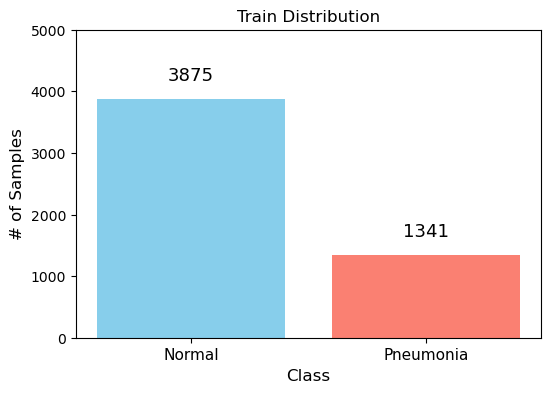

In [5]:
# Create a new figure with the specified size
plt.figure(figsize=(6,4))

# Define the class labels and get the corresponding counts from the dataframe
class_labels = ['Normal', 'Pneumonia']
class_counts = df_train['class'].value_counts()

# Define a list of colors for each bar
colors = ['skyblue', 'salmon']

# Create the bar plot with the specified colors
plt.bar(class_labels, class_counts, color=colors)

#set title
plt.title('Train Distribution')

# Set the x-label and y-label
plt.xlabel('Class', fontsize=12)
plt.ylabel('# of Samples', fontsize=12)

# Set the y-axis limits
plt.ylim(0, 5000)

# Set the x-axis tick labels
plt.xticks(fontsize=11)

# Add count labels above each bar
for i, count in enumerate(class_counts):
    plt.text(i, count + 300, str(count), ha='center', fontsize=13)

# Display the plot
plt.show()

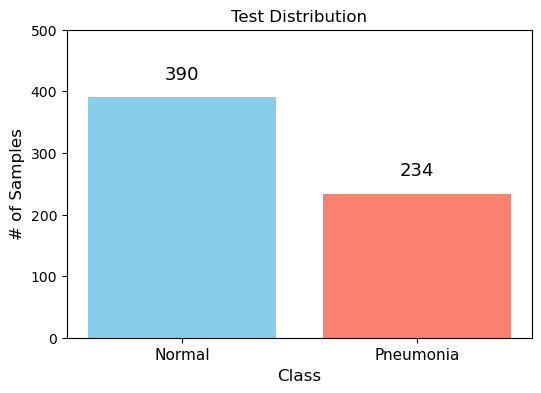

In [6]:
# Create a new figure with the specified size
plt.figure(figsize=(6,4))

# Define the class labels and get the corresponding counts from the dataframe
class_labels = ['Normal', 'Pneumonia']
class_counts = df_test['class'].value_counts()

# Create the bar plot with the specified colors
plt.bar(class_labels, class_counts, color=colors)

#set title
plt.title('Test Distribution')

# Set the x-label and y-label
plt.xlabel('Class', fontsize=12)
plt.ylabel('# of Samples', fontsize=12)

# Set the y-axis limits
plt.ylim(0, 500)

# Set the x-axis tick labels
plt.xticks(fontsize=11)

# Add count labels above each bar
for i, count in enumerate(class_counts):
    plt.text(i, count + 30, str(count), ha='center', fontsize=13)

# Display the plot
plt.show()

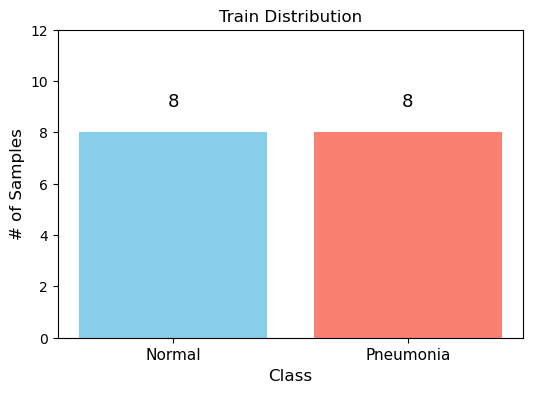

In [7]:
# Create a new figure with the specified size
plt.figure(figsize=(6,4))

# Define the class labels and get the corresponding counts from the dataframe
class_labels = ['Normal', 'Pneumonia']
class_counts = df_val['class'].value_counts()

# Create the bar plot with the specified colors
plt.bar(class_labels, class_counts, color=colors)

#set title
plt.title('Train Distribution')

# Set the x-label and y-label
plt.xlabel('Class', fontsize=12)
plt.ylabel('# of Samples', fontsize=12)

# Set the y-axis limits
plt.ylim(0, 12)

# Set the x-axis tick labels
plt.xticks(fontsize=11)

# Add count labels above each bar
for i, count in enumerate(class_counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=13)

# Display the plot
plt.show()

Now let's create a table that summarizes our findings

In [8]:
# Create a list of dataset names
dataset_names = ['Train', 'Test', 'Validation']

# Create a list of corresponding dataframes
dataframes = [df_train, df_test, df_val]

# Create an empty list to store the balance information
balance_info = []

# Iterate over each dataset and calculate the balance
for dataset_name, df in zip(dataset_names, dataframes):
    normal_count = df[df['class'] == 'Normal'].shape[0]
    pneumonia_count = df[df['class'] == 'Pneumonia'].shape[0]
    total_samples = normal_count + pneumonia_count
    pneumonia_percent = round((pneumonia_count / total_samples) * 100)
    balance_info.append({'Dataset': dataset_name, 'Normal': normal_count, 'Pneumonia': pneumonia_count, 'Percent with Pneumonia': pneumonia_percent})

# Create the balance table
balance_table = pd.DataFrame(balance_info)

# Print the balance table
print(balance_table)

      Dataset  Normal  Pneumonia  Percent with Pneumonia
0       Train    1341       3875                      74
1        Test     234        390                      62
2  Validation       8          8                      50


We say that the main dataset we will be modeling off is quite imbalanced, while the test set is slightly imbalanced, and finally the validation set is perfectly balanced. This will allow us to make sure our model works on all forms of datasets.

### Viewing the Images
Before we move on to preparing our data let's take a look some samples of Normal xrays as well as Pneumonia xrays to see if there is anything interesting there.

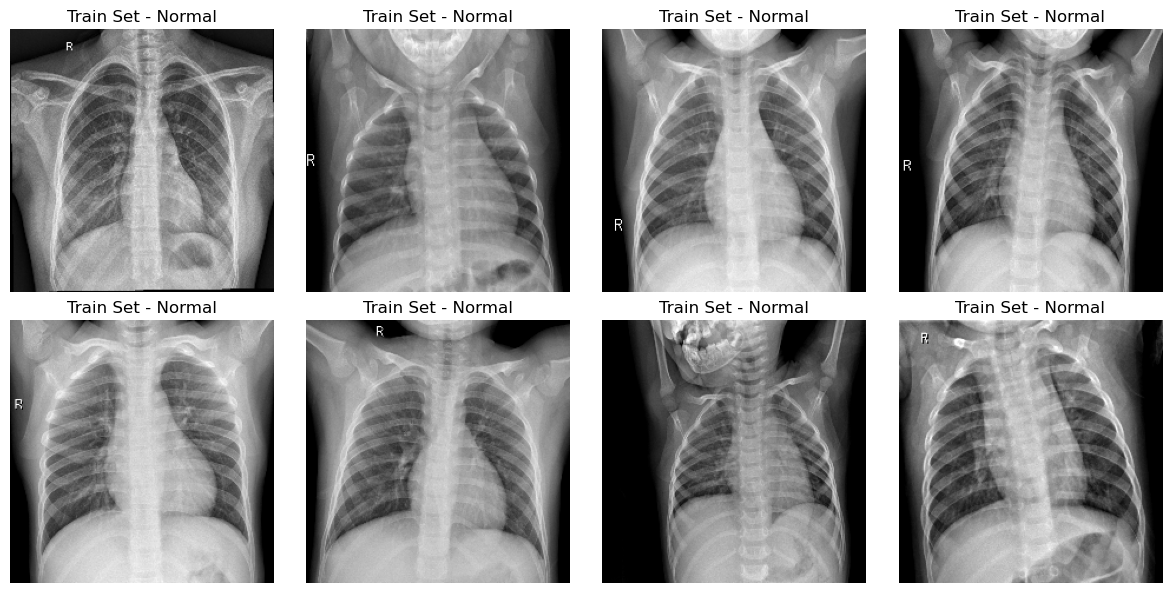

In [9]:
# Set the desired image size
IMG_SIZE = 224

# Create a new figure with the specified size and subplots arrangement
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Iterate over the train_normal images and axes to display the images
for i, (image_path, ax) in enumerate(zip(train_normal[:8], axes.flatten())):
    # Read and resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Display the image in the subplot
    ax.imshow(img)

    # Turn off axis labels
    ax.axis('off')

    # Set the title of the subplot
    ax.set_title('Train Set - Normal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

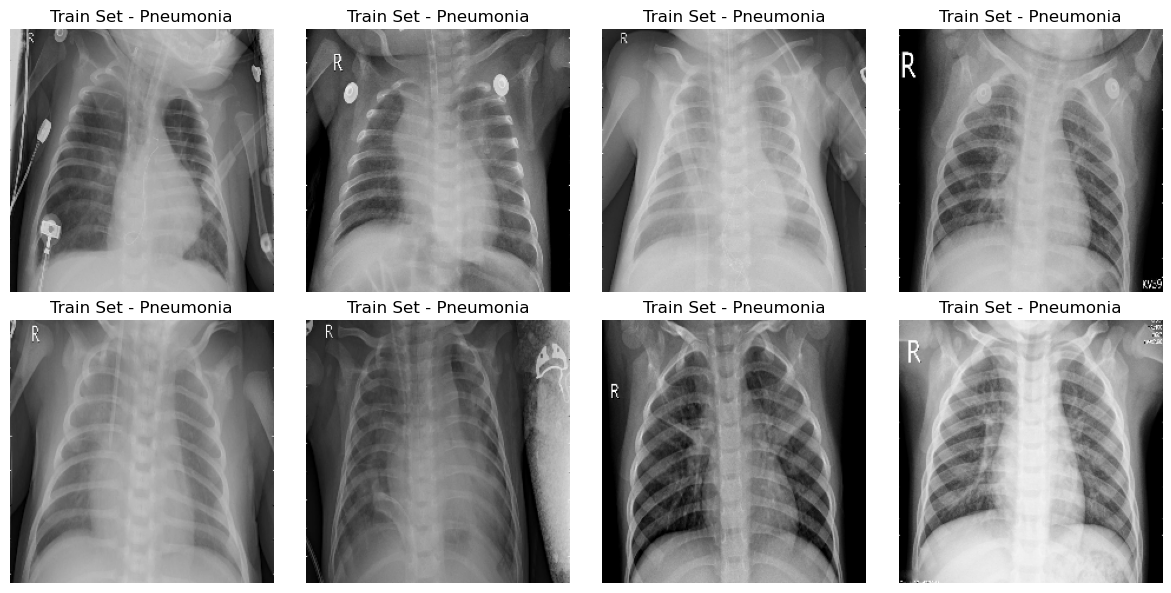

In [10]:
# Create a new figure with the specified size and subplots arrangement
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Iterate over the train_normal images and axes to display the images
for i, (image_path, ax) in enumerate(zip(train_pneumonia[:8], axes.flatten())):
    # Read and resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Display the image in the subplot
    ax.imshow(img)

    # Turn off axis labels
    ax.axis('off')

    # Set the title of the subplot
    ax.set_title('Train Set - Pneumonia')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Obviously, we are not experts but it seems that the Normal patient xrays are a bit cleaner. Let's move on to preprocessing
## Modeling
### Preprocessing Baseline Model
For our Baseline model we'll create a very basic model. The first step to doing this is preparing the data for our model. We'll reload the data in a different form using the ImageDataGenerator and flow_from_directory

In [11]:
#rename the data path
train_data_dir = 'data/xray/train'
test_data_dir = 'data/xray/test'
val_data_dir ='data/xray/val'

# Get all the data in the directory data/train (5216 images), and reshape them
print('Train Images:')
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

print('Test Images:')
# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=624)
print('Val Images:')
# Get all the data in the directory data/train (16 images), and reshape them
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Train Images:
Found 5216 images belonging to 2 classes.
Test Images:
Found 624 images belonging to 2 classes.
Val Images:
Found 16 images belonging to 2 classes.


Now we need to reshape both the images as well as are labels and we are ready to begin modeling.

In [12]:
# Reshape the train, test and val images 
train_img_unrow = train_images.reshape(-1, 64*64*3)
test_img_unrow = test_images.reshape(-1, 64*64*3)
val_img_unrow = val_images.reshape(-1, 64*64*3)

#create new datasets that are transposed versions of the label dataset
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]
val_labels_final = val_labels.T[[1]]

#Transpose again to get the correct shape
train_labels_final = train_labels_final.T
test_labels_final = test_labels_final.T
val_labels_final = val_labels_final.T

### Baseline Model
We'll begin by setting our model as a Sequential model, this means that one layer will build on the next

In [13]:
# Create the baseline model
baseline_model = Sequential()

Metal device set to: Apple M1 Pro


2023-06-28 10:48:19.554993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-28 10:48:19.555152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Add layers
Now that we have initialized a network we will add layers to the network, which include the number of layers, as well as the activation function.

The Dense() class indicates that this layer will be fully connected. 

For our `baseline_model` we'll use one hidden layers with 64 unitswith a 'relu' activation function. Also, since this is the first hidden layer, we'll pass in input_shape=(12288,). Since we are dealing with a multiclass problem (classifying the xrays into 2), we'll use a 'softmax' classifier in order to output 2 class probabilities per case

In [14]:
np.random.seed(123)
#add the hidden layer to the NN with 64 units, and an activation of 'relu'
baseline_model.add(Dense(64, activation='relu', input_shape=(12288,)))

#add the output layer with 1 units and an activation of sigmoid
baseline_model.add(Dense(1, activation='sigmoid'))  # Output layer with 2 unit for binary classification

Now, let's move on to compiling our model. We'll use `'SGD'` as our optimizer for our baseline model. For our loss we'll use binary crossentropy since this is a binary classification problem. 

In [15]:
# Compile the model #(optimizers.RMSprop(lr=0.001)) adam, AdamW
baseline_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Before we run our model lets pull up some summary statistics

In [16]:
#pull up summary statistics
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                786496    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 786,561
Trainable params: 786,561
Non-trainable params: 0
_________________________________________________________________


We see that our model has 786,754 trainable parameters, and this is only our baseline model. 
Now let's move on to actually fitting and running our model.

Before we do that we'll create an early stop function, which stops the model if there is no improvement in the validation set loss. In our case, we need to minimize false positives, because every false positive means we would assume patients don't have pneumonia when they really do. This would lead to lack of treatment, which could lead to possible sickness or even worse. To do this we will monitor the loss in the testing set. Although this is not directly linked to the recall, if the model is a better model overall then most likely the recall will be higher. Later on when we get better models, we will focus closer on recall. In our early stopping parameter, we'll allow the model to run 5 epochs with no improvement before it stops the model.

We'll start out with only 10 epochs and a batch size of 64. We'll also use our test set to test our model

In [37]:
# Define the callbacks, continue training for 5 epochs before stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

In [38]:
# Train the model
results_baseline = baseline_model.fit(train_img_unrow, train_labels_final, epochs=10, 
                                      batch_size=64, callbacks=early_stopping,
                                      validation_data=(test_img_unrow, test_labels_final))

Epoch 1/10
 1/82 [..............................] - ETA: 12s - loss: 0.5463 - accuracy: 0.7969

2023-06-28 11:12:52.937090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 11ms/step - loss: 0.5817 - accuracy: 0.7429 - val_loss: 0.6681 - val_accuracy: 0.6250
Epoch 2/10
 1/82 [..............................] - ETA: 0s - loss: 0.4924 - accuracy: 0.8594

2023-06-28 11:12:53.819808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.5783 - accuracy: 0.7429 - val_loss: 0.6709 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5759 - accuracy: 0.7429 - val_loss: 0.6736 - val_accuracy: 0.6250
Epoch 4/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5743 - accuracy: 0.7429 - val_loss: 0.6762 - val_accuracy: 0.6250
Epoch 5/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5731 - accuracy: 0.7429 - val_loss: 0.6786 - val_accuracy: 0.6250
Epoch 6/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5722 - accuracy: 0.7429 - val_loss: 0.6809 - val_accuracy: 0.6250


Now, let's create a function that takes in our results and plots how they did in terms of accuracy and loss on both the training set as well as the validation set

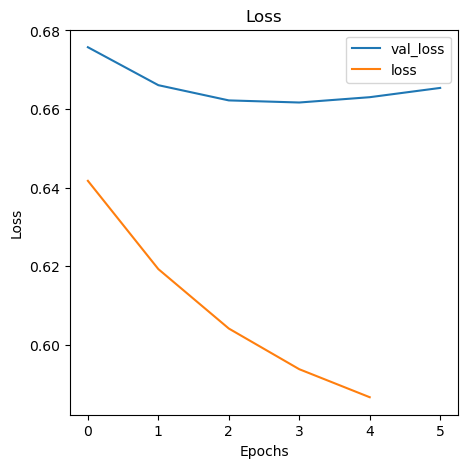

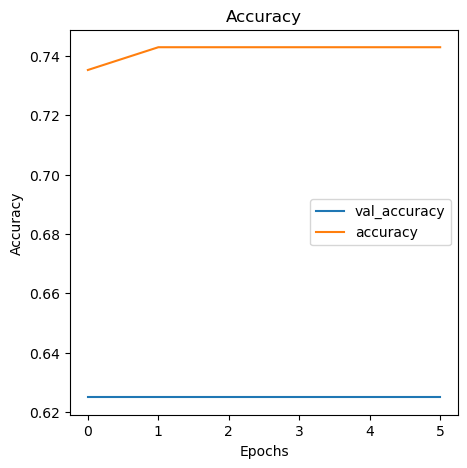

In [19]:
#name function visualize_training_results
def visualize_training_results(results):
    #set the history
    history = results.history
    
    #create figure for loss
    plt.figure(figsize=(5,5))
    
    # Plot the validation set loss below 100 followed by the training set loss below 1000
    plt.plot([loss for loss in history['val_loss'] if loss < 1000])
    plt.plot([loss for loss in history['loss'] if loss < 1000])
    
    #ad a legend
    plt.legend(['val_loss', 'loss'])
    
    #label the graph and axes
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    #create a figure for accuracy
    plt.figure(figsize=(5,5))
    
    #plot the accuracy for both the validation and training set
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    
    #create a legend
    plt.legend(['val_accuracy', 'accuracy'])
    
    #Label the graph and it's axes
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_training_results(results_baseline)

Being that the loss and accuracy remained roughly the same for both sets over the course of our model, we can say that this isn't a great model. Our loss for the training set ended up being around .6, while it was around .75 for the validation set. Additionally, our accuracy for the training set remained around 75% while our accuracy for the validation set was only a mere 62.5%, which is on average barely better than random guessing. Our model stopped early as there was no improvement. Let's move on to a far more complex model.

## Convoluted Neural Network(CNN)
### Data Preprocessing for CNN
To prepare the images for our models, we utilize data generators from keras. These generators allow us to perform various preprocessing tasks which include data augmentation.

We will rescale the pixel values of the training set and introduce random transformations to augment the data. We will rescale the values for the test set, but will not perform any transformations on them. 

Before we do any of that, first let's create an additional validation set from the train set, as our current validation set is quite small, and it is possible that we may get good results on it, by chance. We will use the new val_df that we create as our new validation set when we train our model. Then we will evaluate our model on the testing set, which will ensure that the model works even with a different ratio of xrays with pneumonia.

In [24]:
# create a seed for reproducibility
SEED = 123

# split the df_train into a new train_df and val_df. Use 18% of the data for the val df
train_df, val_df = train_test_split(df_train, test_size = 0.18, 
                                    random_state = SEED, stratify = df_train['class'])

#confirm that it worked
print(len(train_df))
print(len(val_df))

4277
939


Now, we will use our data generators

In [27]:
BATCH = 32  # Batch size for training
# Define the train and validation data generators
train_datagen = ImageDataGenerator(
    rescale=1/255.,                  # Rescale pixel values to range [0, 1]
    zoom_range=0.1,                  # Randomly zoom the images by 10%
    #rotation_range=0.1,              # Randomly rotate the images by 10 degrees
    width_shift_range=0.1,           # Randomly shift the width of the images by 10%
    height_shift_range=0.1           # Randomly shift the height of the images by 10%
)

val_datagen = ImageDataGenerator(
    rescale=1/255.                    # Rescale pixel values to range [0, 1]
)

# Create the training data generator
ds_train = train_datagen.flow_from_dataframe(
    train_df,                        # DataFrame containing the training data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=BATCH,                 # Number of images per batch
    seed=SEED                         # Seed for reproducibility
)

# Create the validation data generator
ds_val = val_datagen.flow_from_dataframe(
    val_df,                          # DataFrame containing the validation data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=BATCH,                 # Number of images per batch
    seed=SEED                         # Seed for reproducibility
)

# Create the test data generator
ds_test = val_datagen.flow_from_dataframe(
    df_test,                         # DataFrame containing the test data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=1,                     # Each batch contains a single image
    shuffle=False                     # Do not shuffle the test images
)

Found 4277 validated image filenames belonging to 2 classes.
Found 939 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### CNN

Now let's create our first CNN. Before doing so we'll create an early stop function and a plateau function. The early stop will tell the model to stop if the model is no longer improving in a certain area. As stated earlier the area we will be monitoring is loss on the validation set, because the better the model is overall, the higher the recall will be. We will allow the model to run 5 epochs with no improvement before stopping. Additionally, if the change is so minute, we don't want to consider that as a decrease in loss. As such, we will set the minimum value of change that needs to be reached, as .0000001. Lastly we will add a parameter that tells the model to use the best weights found for the final model, and not just the last weights.

In [39]:
# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',             # Metric to monitor for early stopping
    patience=5,                      # Number of epochs with no improvement before stopping
    min_delta=1e-7,                  # Minimum change in the monitored metric to be considered an improvement
    restore_best_weights=True        # Restore the weights from the epoch with the best monitored metric
)

Additionally, we will also use the `ReduceLROnPlateau` fucntion which reduces the learning rate while the model is training the monitored metric(`val_loss`) is no longer improving. The learning rate controls the step size of the model or how quickly the model adjusts itself based on the training data. If the `val_loss` has not improved within 2 epochs, we will reduce the learning rate by .2, and run the new learning rate immediately. Again, we will make sure that there is a change of atleast .0000001, and create a message statement when the learning rate is reduced

In [33]:
# Define the ReduceLROnPlateau callback
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',              # Metric to monitor for reducing learning rate
    factor=0.2,                      # Factor by which the learning rate will be reduced
    patience=2,                      # Number of epochs with no improvement before reducing learning rate
    min_delt=1e-7,                   # Minimum change in the monitored metric to be considered an improvement
    cooldown=0,                      # Number of epochs to wait after reducing learning rate before resuming normal operation
    verbose=1                        # Verbosity mode (0: quiet, 1: update messages)
)

In [34]:
def get_model():
    
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)  # Apply a 2D convolutional layer with 16 filters and 3x3 kernel size
    x = layers.BatchNormalization()(x)  # Apply batch normalization
    x = layers.Activation('relu')(x)  # Apply ReLU activation function
    x = layers.MaxPool2D()(x)  # Apply 2D max pooling
    x = layers.Dropout(0.2)(x)  # Apply dropout with a rate of 0.2

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)  # Apply a 2D convolutional layer with 32 filters and 3x3 kernel size
    x = layers.BatchNormalization()(x)  # Apply batch normalization
    x = layers.Activation('relu')(x)  # Apply ReLU activation function
    x = layers.MaxPool2D()(x)  # Apply 2D max pooling
    x = layers.Dropout(0.2)(x)  # Apply dropout with a rate of 0.2
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)  # Apply a 2D convolutional layer with 64 filters and 3x3 kernel size
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)  # Apply another 2D convolutional layer with 64 filters and 3x3 kernel size
    x = layers.BatchNormalization()(x)  # Apply batch normalization
    x = layers.Activation('relu')(x)  # Apply ReLU activation function
    x = layers.MaxPool2D()(x)  # Apply 2D max pooling
    x = layers.Dropout(0.4)(x)  # Apply dropout with a rate of 0.4

    # Head
    # x = layers.BatchNormalization()(x)  # Batch normalization (commented out)
    x = layers.Flatten()(x)  # Flatten the tensor
    x = layers.Dense(64, activation='relu')(x)  # Apply a fully connected layer with 64 units and ReLU activation
    x = layers.Dropout(0.5)(x)  # Apply dropout with a rate of 0.5
    
    # Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)  # Apply a fully connected layer with 1 unit and sigmoid activation
    
    model = keras.Model(inputs=[inputs], outputs=output)  # Create the model
    
    return model


In [35]:
keras.backend.clear_session()  # Clear the Keras session to release memory and resources

model = get_model()  # Create the model using the `get_model()` function
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')
# Compile the model with binary crossentropy loss, Adam optimizer with learning rate of 3e-5, and binary accuracy metric

model.summary()  # Print a summary of the model architecture


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [36]:
history = model.fit(ds_train,  # Train the model using the training dataset
                    batch_size=BATCH, epochs=50,  # Set the batch size and number of epochs
                    validation_data=ds_val,  # Use the validation dataset for validation during training
                    callbacks=[early_stopping, plateau],  # Apply early stopping and plateau callbacks during training
                    steps_per_epoch=(len(train_df) / BATCH),  # Set the number of steps per epoch based on the training dataset size and batch size
                    validation_steps=(len(val_df) / BATCH)  # Set the number of validation steps based on the validation dataset size and batch size
                    )

Epoch 1/50


2023-06-28 11:02:20.807732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: 0s - loss: 0.4464 - binary_accuracy: 0.8010

2023-06-28 11:03:17.549192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 63s 440ms/step - loss: 0.4464 - binary_accuracy: 0.8010 - val_loss: 0.7266 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 2/50
133/133 [==============================] - 56s 421ms/step - loss: 0.2595 - binary_accuracy: 0.8901 - val_loss: 1.0688 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 3/50
134/133 [==============================] - ETA: 0s - loss: 0.2175 - binary_accuracy: 0.9133
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
133/133 [==============================] - 56s 420ms/step - loss: 0.2175 - binary_accuracy: 0.9133 - val_loss: 1.1823 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 4/50
133/133 [==============================] - 56s 419ms/step - loss: 0.1882 - binary_accuracy: 0.9231 - val_loss: 0.7653 - val_binary_accuracy: 0.7433 - lr: 6.0000e-06
Epoch 5/50
133/133 [==============================] - 56s 421ms/step - loss: 0.1718 - binary_accuracy: 0.9306 - val_loss: 0.2550 - val_bin

In [ ]:
# Set the number of training steps per epoch
steps_per_epoch = len(df_train) // BATCH

# Set the number of validation steps
validation_steps = len(df_val) // BATCH

# Fit the model to the training data
history = model.fit(
    ds_train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps=validation_steps
)

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(ds_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a basic model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Update the output shape for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

references
- https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning
- https://www.kaggle.com/code/pujithagrandhi/classification-of-pneumonia-using-cnn
- https://www.kaggle.com/code/bennyfung/pneumonia-two-stages-vgg16-densenet-inception-86